### **Step 1: Load Data & Split into Train/Test**

In [54]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# ✅ Define Paths (Multiple Folders per Class)
class_0_paths = ["Multiplexer-new/Mode_1/Mode_1-high_bandwidth", "Multiplexer-new/Mode_1/Mode_1-low_bandwidth"]
class_1_paths = ["Multiplexer-new/Mode_2/Mode_2-high_bandwidth", "Multiplexer-new/Mode_2/Mode_2-low_bandwidth"]

# ✅ Function to Load Images from Multiple Folders
def load_images(class_0_folders, class_1_folders, img_size=(256, 256)):
    images, labels = [], []

    # Load Class 0 images from multiple folders
    for folder in class_0_folders:
        if not os.path.exists(folder):  # Check if folder exists
            print(f"Warning: Folder {folder} does not exist!")
            continue
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, img_size) / 255.0
                images.append(img)
                labels.append(0)

    # Load Class 1 images from multiple folders
    for folder in class_1_folders:
        if not os.path.exists(folder):  # Check if folder exists
            print(f"Warning: Folder {folder} does not exist!")
            continue
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, img_size) / 255.0
                images.append(img)
                labels.append(1)

    # Convert to NumPy arrays
    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)  # Add channel dimension
    labels = np.array(labels)
    return images, labels

# ✅ Load the dataset from multiple folders
x_data, y_data = load_images(class_0_paths, class_1_paths)

# ✅ Split into Train (80%) and Test (20%)
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, stratify=y_data, random_state=42
)

# ✅ Print dataset info
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


x_train shape: (335, 256, 256, 1), y_train shape: (335,)
x_test shape: (84, 256, 256, 1), y_test shape: (84,)


### **Step 2: Apply Augmentation on Training Data**

#### Data Augmentation v1.0

In [55]:
# ✅ Stronger Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.5,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

# ✅ Create Augmented Training Dataset
train_ds = train_datagen.flow(x_train, y_train, batch_size=16)

# ✅ Test Data (No Augmentation)
val_ds = (x_test, y_test)


#### Data Augmentation v2.0

In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Adjusted Data Augmentation (Less Aggressive)
train_datagen = ImageDataGenerator(
    rotation_range=25,  # Reduced from 45 (less distortion)
    width_shift_range=0.2,  # Reduced
    height_shift_range=0.2,  # Reduced
    shear_range=0.2,  # Reduced
    zoom_range=0.3,  # Reduced
    brightness_range=[0.8, 1.2],  # Less Brightness Change
    horizontal_flip=True,
    vertical_flip=False,  # Disable vertical flipping for structured images
    fill_mode="nearest"
)

# ✅ Augment Only Training Data
train_ds = train_datagen.flow(x_train, y_train)

# ✅ Validation Data (No Augmentation)
val_ds = (x_test, y_test)


### **Step 3: Create CNN**

#### CNN v2.0

In [46]:
'''
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# ✅ Lightweight CNN for Small Dataset
model = Sequential([
    # Convolutional Layer 1
    Conv2D(32, (4,4), activation='relu', input_shape=(256, 256, 1), padding='same'),
    MaxPooling2D((2,2)),

    # Convolutional Layer 2
    Conv2D(32, (4,4), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    # Flatten & Fully Connected Layers
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),  # Dropout to prevent overfitting
    Dense(32, activation='relu'),
    Dropout(0.3),

    # Output Layer
    Dense(1, activation='sigmoid')  # Binary Classification
])

# ✅ Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Start with 1e-3, reduce if needed
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ✅ Display Model Summary
model.summary()
'''

"\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization\n\n# ✅ Lightweight CNN for Small Dataset\nmodel = Sequential([\n    # Convolutional Layer 1\n    Conv2D(32, (4,4), activation='relu', input_shape=(256, 256, 1), padding='same'),\n    MaxPooling2D((2,2)),\n\n    # Convolutional Layer 2\n    Conv2D(32, (4,4), activation='relu', padding='same'),\n    MaxPooling2D((2,2)),\n\n    # Flatten & Fully Connected Layers\n    Flatten(),\n    Dense(64, activation='relu'),\n    Dropout(0.4),  # Dropout to prevent overfitting\n    Dense(32, activation='relu'),\n    Dropout(0.3),\n\n    # Output Layer\n    Dense(1, activation='sigmoid')  # Binary Classification\n])\n\n# ✅ Compile Model\nmodel.compile(\n    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Start with 1e-3, reduce if needed\n    loss='binary_crossentropy',\n    metrics=['accuracy']\n)\n\n# ✅ Display Mod

#### CNN v3.0

In [58]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, SpatialDropout2D
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau

# ✅ Define the Model
model = Sequential()

# Convolutional Layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Global Average Pooling (Reduces overfitting)
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # 🔻 Reduced neurons (simpler)
model.add(Dropout(0.4))  # 🔻 Prevent overfitting
model.add(Dense(64, activation='relu'))  # 🔻 Reduced layer size
model.add(Dropout(0.3))

# 🔹 Output Layer for **Binary Classification**
model.add(Dense(1, activation='sigmoid'))  # 🔄 Changed from 3 classes → 1 neuron with `sigmoid`

# ✅ Compile the Model for Binary Classification
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy',  # 🔄 Changed from `categorical_crossentropy`
    metrics=['accuracy']
)

# ✅ Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# ✅ Display Model Architecture
model.summary()



/Users/nayanthara/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_4             │ (None, 127, 127, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,401 (462.50 KB)

 Trainable params: 117,953 (460.75 KB)

 Non-trainable params: 448 (1.75 KB)

### **Step 3: Train the Model**

In [64]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# ✅ Learning Rate Scheduling & Early Stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ✅ Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,  # Increase epochs for better learning
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)


Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 945ms/step - accuracy: 0.5222 - loss: 1.8278 - val_accuracy: 0.5357 - val_loss: 1.7578 - learning_rate: 0.0010
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 902ms/step - accuracy: 0.5038 - loss: 1.7649 - val_accuracy: 0.5357 - val_loss: 1.6697 - learning_rate: 0.0010
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 944ms/step - accuracy: 0.4891 - loss: 1.6717 - val_accuracy: 0.5357 - val_loss: 1.5892 - learning_rate: 0.0010
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 864ms/step - accuracy: 0.4953 - loss: 1.5936 - val_accuracy: 0.5357 - val_loss: 1.5158 - learning_rate: 0.0010
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 848ms/step - accuracy: 0.4880 - loss: 1.5289 - val_accuracy: 0.5357 - val_loss: 1.4486 - learning_rate: 0.0010
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 916ms/step - accuracy: 0.5427 - loss: 1.4339 - val_accuracy: 0.5357 - val_loss: 1.3867 - learning_rate: 0.0010
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 977ms/step - accuracy: 0.5632 - loss: 1.

### *Code to Delete all files in LIME_Explanations_Multiplexers Folder*

In [51]:
'''
import os
import shutil

folder_path = "LIME_Explanations_Multiplexers"

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    # If it's a file, remove it directly
    if os.path.isfile(file_path):
        os.remove(file_path)
    # If it's a folder, remove it (and all contents) recursively
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)

print(f"All files and folders in '{folder_path}' have been deleted.")
'''

'\nimport os\nimport shutil\n\nfolder_path = "LIME_Explanations_Multiplexers"\n\nfor filename in os.listdir(folder_path):\n    file_path = os.path.join(folder_path, filename)\n    # If it\'s a file, remove it directly\n    if os.path.isfile(file_path):\n        os.remove(file_path)\n    # If it\'s a folder, remove it (and all contents) recursively\n    elif os.path.isdir(file_path):\n        shutil.rmtree(file_path)\n\nprint(f"All files and folders in \'{folder_path}\' have been deleted.")\n'

### **LIME Code for Multiplexers**

In [65]:
import os
from lime import lime_image
import sys
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import cv2
import numpy as np

# ✅ Suppress LIME's Output (to avoid clutter)
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

# ✅ Combine Training & Testing Data
all_images = np.concatenate((x_train, x_test), axis=0)
all_labels = np.concatenate((y_train, y_test), axis=0)

# ✅ Define Prediction Function for Binary Classification
def predict_fn(images):
    images = images[:, :, :, 0]  # Extract grayscale channel
    images = np.expand_dims(images, axis=-1)  # Add back single channel
    preds = model.predict(images)  # Get predictions
    
    # 🔹 Convert sigmoid output (0-1) to a two-class probability format
    return np.hstack([1 - preds, preds])  # Converts [0.8] → [0.2, 0.8]

# ✅ Initialize LIME Explainer
explainer = lime_image.LimeImageExplainer()

# ✅ Define Output Directory for LIME Explanations
output_dir = "LIME_Explanations_Multiplexers"
os.makedirs(output_dir, exist_ok=True)

# ✅ Loop Through All Images & Generate LIME Explanations
for i, image in enumerate(all_images):
    # Convert grayscale image to RGB for LIME compatibility
    sample_image = cv2.cvtColor((image.squeeze() * 255).astype('uint8'), cv2.COLOR_GRAY2RGB)

    # ✅ Run LIME Explanation
    with SuppressOutput():  # Suppress LIME's verbose output
        explanation = explainer.explain_instance(
            sample_image.astype('double'),
            predict_fn,
            top_labels=1,  # Only 1 class label needed for binary classification
            hide_color=0,
            num_samples=1000  # Number of perturbations
        )

    # ✅ Get LIME mask & explanation for the predicted class
    predicted_class = explanation.top_labels[0]  # This should be 0 or 1
    temp, mask = explanation.get_image_and_mask(
        predicted_class,  
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    # ✅ Define Subfolder for Each Class (0 or 1)
    class_folder = os.path.join(output_dir, f"Class_{predicted_class}")
    os.makedirs(class_folder, exist_ok=True)

    # ✅ Save Original Image
    original_image_path = os.path.join(class_folder, f"Multiplexer_Original_Image_{i}.png")
    plt.imsave(original_image_path, sample_image[:, :, 0] / 255.0, cmap='gray')

    # ✅ Save LIME Explanation with Boundaries
    explanation_image_path = os.path.join(class_folder, f"Multiplexer_LIME_Explanation_{i}.png")
    plt.imsave(explanation_image_path, mark_boundaries(temp / 255.0, mask, color=(0.5, 0, 0.5)))  # Purple color


    # ✅ Save Mask Directly
    mask_path = os.path.join(class_folder, f"Mask_{i}.png")
    plt.imsave(mask_path, mask, cmap='gray')

print(f"LIME explanations saved in {output_dir}")


LIME explanations saved in LIME_Explanations_Multiplexers


### **To check if the folder exists*

In [71]:
import os

folder_path = "LIME_Explanations_Multiplexers/Class_1"

# Check if the folder exists
if not os.path.exists(folder_path):
    print("❌ Folder does NOT exist! Check the path.")
else:
    print("✅ Folder exists!")


✅ Folder exists!


In [72]:
files = os.listdir(folder_path)
print(f"📂 Found {len(files)} files inside the folder: {files}")


📂 Found 1257 files inside the folder: ['Mask_318.png', 'Mask_330.png', 'Mask_324.png', 'Multiplexer_LIME_Explanation_323.png', 'Multiplexer_LIME_Explanation_337.png', 'Multiplexer_Original_Image_238.png', 'Multiplexer_Original_Image_204.png', 'Mask_132.png', 'Mask_126.png', 'Multiplexer_Original_Image_210.png', 'Multiplexer_LIME_Explanation_121.png', 'Multiplexer_LIME_Explanation_135.png', 'Multiplexer_LIME_Explanation_109.png', 'Multiplexer_Original_Image_358.png', 'Multiplexer_Original_Image_416.png', 'Multiplexer_Original_Image_370.png', 'Multiplexer_Original_Image_364.png', 'Multiplexer_Original_Image_402.png', 'Mask_278.png', 'Multiplexer_LIME_Explanation_294.png', 'Multiplexer_LIME_Explanation_51.png', 'Multiplexer_Original_Image_50.png', 'Multiplexer_Original_Image_44.png', 'Multiplexer_LIME_Explanation_45.png', 'Multiplexer_LIME_Explanation_280.png', 'Mask_244.png', 'Multiplexer_Original_Image_172.png', 'Mask_63.png', 'Mask_77.png', 'Multiplexer_Original_Image_78.png', 'Multipl

📂 Found 419 mask images. Displaying the first one...
✅ Successfully loaded Mask_0.png with shape (256, 256)


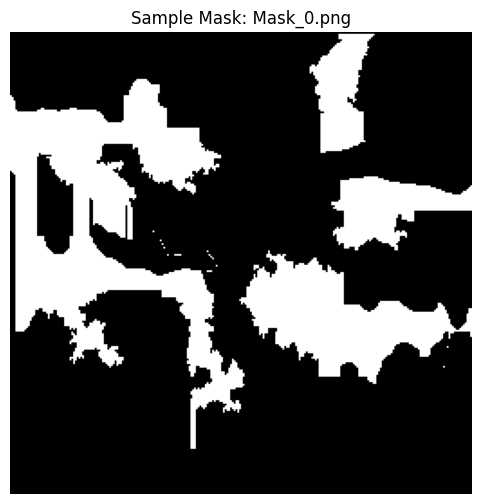

In [74]:
import os
import cv2
import matplotlib.pyplot as plt

# Define folder path
folder_path = "LIME_Explanations_Multiplexers/Class_1"

# Get list of files in folder
file_names = sorted([f for f in os.listdir(folder_path) if f.startswith("Mask_") and f.endswith(".png")])

# Check if files exist
if len(file_names) == 0:
    print("❌ No mask images found in the folder!")
else:
    print(f"📂 Found {len(file_names)} mask images. Displaying the first one...")

    # Load the first image
    test_img_path = os.path.join(folder_path, file_names[0])
    test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)

    if test_img is None:
        print(f"❌ Error: Could not load {file_names[0]}. Check if it's a valid image.")
    else:
        print(f"✅ Successfully loaded {file_names[0]} with shape {test_img.shape}")

        # Display image
        plt.figure(figsize=(6, 6))
        plt.imshow(test_img, cmap='gray')
        plt.title(f"Sample Mask: {file_names[0]}")
        plt.axis('off')
        plt.show()


### **LIME Contextualisation for Multiplexers**

#### Load LIME Explanation Masks

In [75]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define folder path
folder_path = "LIME_Explanations_Multiplexers/Class_1"

# Load all mask images
mask_images = []
file_names = sorted([f for f in os.listdir(folder_path) if f.startswith("Mask_") and f.endswith(".png")])

for file in file_names:
    img_path = os.path.join(folder_path, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    mask_images.append(img)

# Convert list to numpy array for analysis
mask_images = np.array(mask_images)

print(f"Loaded {len(mask_images)} mask images with shape: {mask_images[0].shape}")


Loaded 419 mask images with shape: (256, 256)


#### Visualise a Few LIME Masks

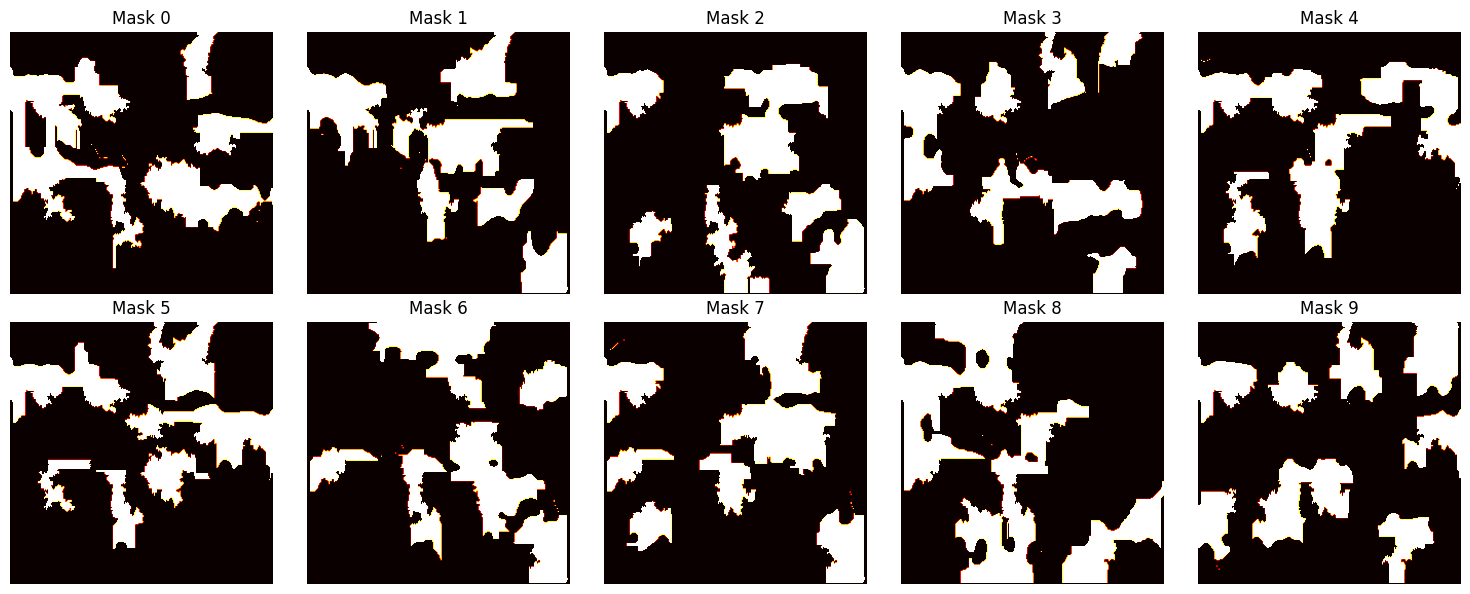

In [76]:
# Plot a few LIME mask images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):  # Display first 10 masks
    axes[i].imshow(mask_images[i], cmap='hot')
    axes[i].set_title(f"Mask {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


#### Compute Aggregate Stats

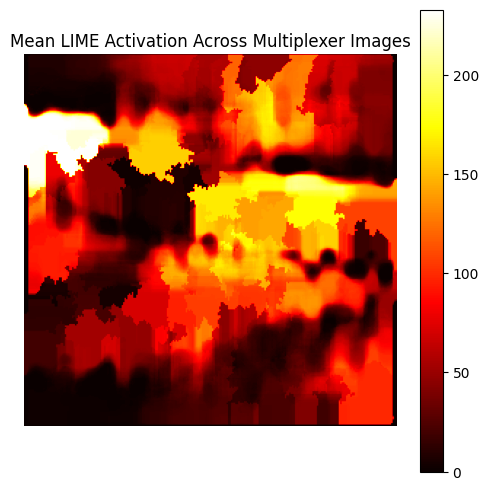

In [77]:
# Compute mean LIME mask across all images
mean_mask = np.mean(mask_images, axis=0)

# Plot the mean LIME explanation
plt.figure(figsize=(6, 6))
plt.imshow(mean_mask, cmap='hot')
plt.title("Mean LIME Activation Across Multiplexer Images")
plt.colorbar()
plt.axis('off')
plt.show()


#### Standard Deviations of LIME Activations

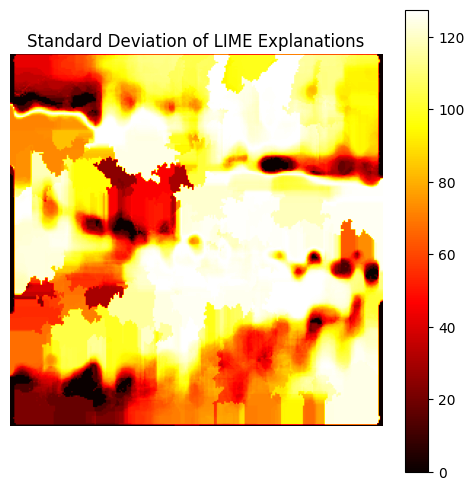

In [78]:
# Compute standard deviation across all masks
std_mask = np.std(mask_images, axis=0)

# Plot the standard deviation map
plt.figure(figsize=(6, 6))
plt.imshow(std_mask, cmap='hot')
plt.title("Standard Deviation of LIME Explanations")
plt.colorbar()
plt.axis('off')
plt.show()


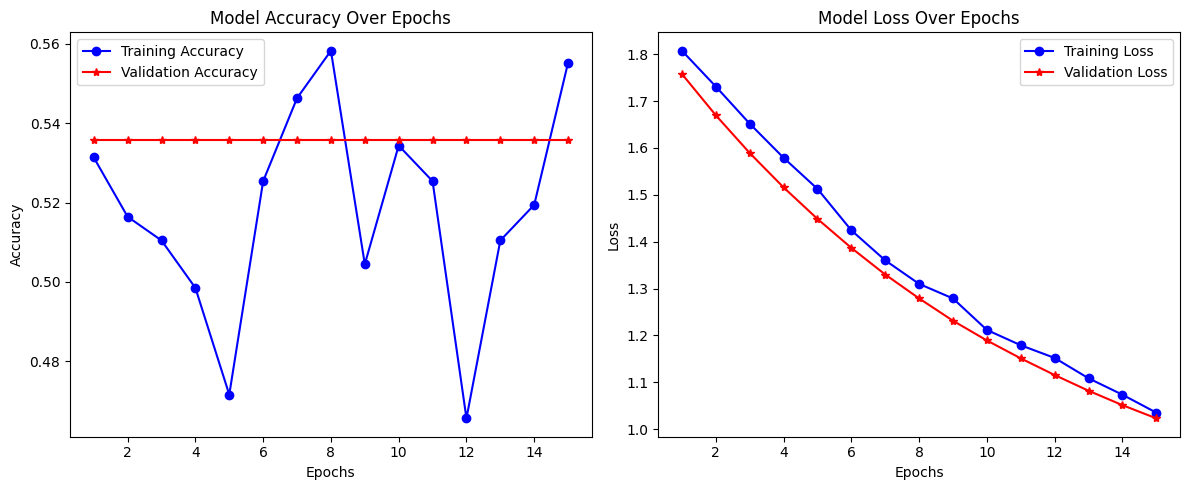

In [81]:
import matplotlib.pyplot as plt

# ✅ Extract values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# 🔹 Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 🔹 Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
